In [1]:
import os
import flow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensortools as tt
import seaborn as sns
import pandas as pd
from copy import deepcopy
from cascade import df
from cascade import tca

/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: All-NaN axis encountered
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: All-NaN axis encountered


KeyboardInterrupt: 

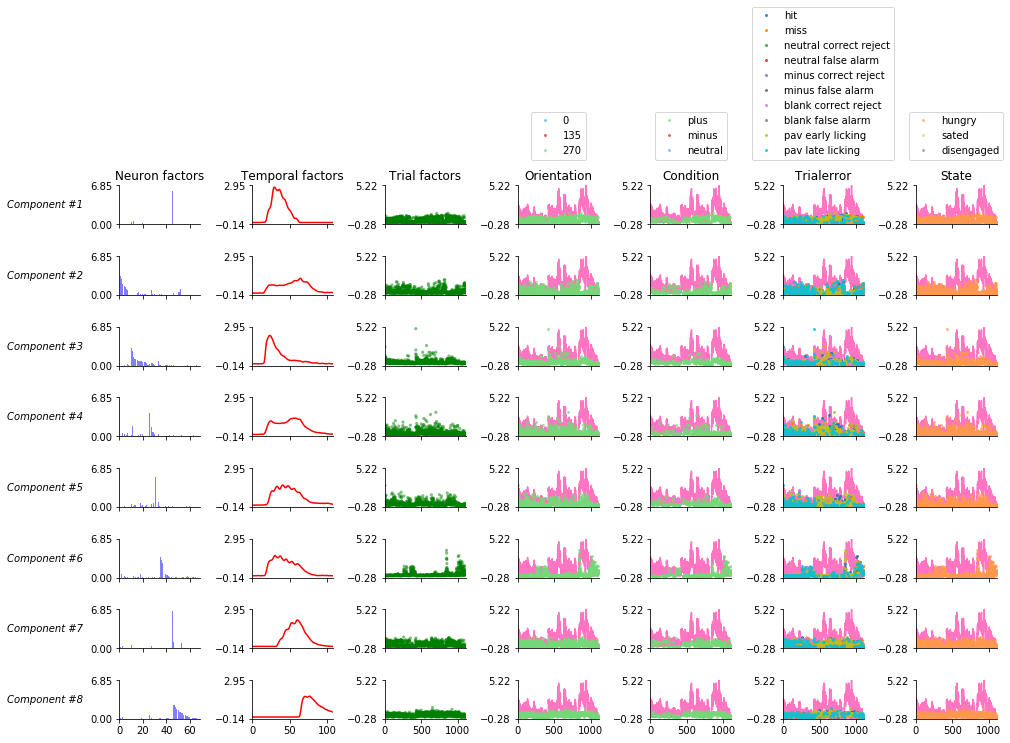

In [109]:
mouse='OA27'
trace_type='zscore_iti'
method='ncp_bcd'
cs=''
warp=False
verbose=False
extra_col=4
alpha = 0.6
plot_running=True

"""
Plot TCA factors for all days and ranks/componenets for
TCA decomposition ensembles.

Parameters:
-----------
mouse : str; mouse name
trace_type : str; dff, zscore, deconvolved
method : str; TCA fit method from tensortools

Returns:
--------
Saves figures to .../analysis folder  .../factors
"""

# plotting options for the unconstrained and nonnegative models.
plot_options = {
  'cp_als': {
    'line_kw': {
      'color': 'red',
      'label': 'cp_als',
    },
    'scatter_kw': {
      'color': 'green',
      'alpha': 0.5,
    },
    'bar_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
  'ncp_hals': {
    'line_kw': {
      'color': 'red',
      'label': 'ncp_hals',
    },
    'scatter_kw': {
      'color': 'green',
      'alpha': 0.5,
    },
    'bar_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
  'ncp_bcd': {
    'line_kw': {
      'color': 'red',
      'label': 'ncp_bcd',
    },
    'scatter_kw': {
      'color': 'green',
      'alpha': 0.5,
    },
    'bar_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
}

days = flow.metadata.DateSorter.frommeta(mice=[mouse], tags=None)

for c, day1 in enumerate(days, 0):
    try:
        day2 = days[c+1]
    except IndexError:
        print('done.')
        break

    # create folder structure if needed
    cs_tag = '' if len(cs) == 0 else ' ' + str(cs)
    warp_tag = '' if warp is False else ' warp'
    folder_name = 'tensors paired ' + str(trace_type) + cs_tag + warp_tag

    # load
    out_dir = os.path.join(flow.paths.outd, str(day1.mouse))
    if not os.path.isdir(out_dir): os.mkdir(out_dir)
    load_dir = os.path.join(out_dir, folder_name)
    if not os.path.isdir(load_dir): os.mkdir(load_dir)
    tensor_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                     + '_' + str(day2.date) + '_pair_decomp_' + str(trace_type) + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                 + '_' + str(day2.date) + '_df_pair_meta.pkl')
    # save
    ana_dir = os.path.join(flow.paths.graphd, str(day1.mouse))
    if not os.path.isdir(ana_dir): os.mkdir(ana_dir)
    save_dir = os.path.join(ana_dir, folder_name)
    if not os.path.isdir(save_dir): os.mkdir(save_dir)
    save_dir = os.path.join(save_dir, 'factors annotated')
    if not os.path.isdir(save_dir): os.mkdir(save_dir)

    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    meta = pd.read_pickle(meta_path)
    orientation = meta['orientation']
    trial_num = np.arange(0, len(orientation))
    condition = meta['condition']
    trialerror = meta['trialerror']
    hunger = meta['hunger']
    speed = meta['speed']

    # make necessary dirs
    date_dir = os.path.join(save_dir, str(day1.date) + '_' + str(day2.date) + ' ' + method)
    if not os.path.isdir(date_dir):
        os.mkdir(date_dir)

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

    for r in sort_ensemble.results:

        U = sort_ensemble.results[r][0].factors
        
        fig, axes = plt.subplots(U.rank, U.ndim + extra_col, figsize=(9 + extra_col, U.rank))
        figt = tt.plot_factors(U, plots=['bar', 'line', 'scatter'],
                        axes=None,
                        fig=fig,
                        scatter_kw=plot_options[method]['scatter_kw'],
                        line_kw=plot_options[method]['line_kw'],
                        bar_kw=plot_options[method]['bar_kw'])
        ax = figt[0].axes
        ax[0].set_title('Neuron factors')
        ax[1].set_title('Temporal factors')
        ax[2].set_title('Trial factors')
        
        # reshape for easier indexing
        ax = np.array(ax).reshape((U.rank, -1))
        
        for col in range(3, 3+extra_col):
            for i in range(U.rank):
                
                # get axis values
                y_lim = ax[i, 2].get_ylim()
                x_lim = ax[i, 2].get_xlim()
                y_ticks = ax[i, 2].get_yticks()
                y_tickl = ax[i, 2].get_yticklabels()
                x_ticks = ax[i, 2].get_xticks()
                x_tickl = ax[i, 2].get_xticklabels()
                
                # running
                if plot_running:
                    scale_by = np.nanmax(speed)/y_lim[1]
                    if not np.isnan(scale_by):
                        ax[i, col].plot(np.array(speed.tolist())/scale_by, color=[1, 0.1, 0.6, 0.6])
                        # , label='speed')

                # Orientation - main variable to plot
                if col == 3:
                    ori_vals = [0, 135, 270]
                    color_vals = [[0.28, 0.68, 0.93, alpha], [0.84, 0.12, 0.13, alpha], [0.46, 0.85, 0.47, alpha]]
                    for k in range(0, 3):
                        ax[i, col].plot(trial_num[orientation==ori_vals[k]],
                                                       U.factors[2][orientation==ori_vals[k], i], 'o',
                                                       label=str(ori_vals[k]), color=color_vals[k], markersize=2)
                        
                    if i == 0:
                        ax[i, col].set_title('Orientation')
                        ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center', borderaxespad=2.5)
                elif col == 4:
                    cs_vals = ['plus', 'minus', 'neutral']
                    cs_labels = ['plus', 'minus', 'neutral']
                    color_vals = [[0.46, 0.85, 0.47, alpha], [0.84, 0.12, 0.13, alpha], [0.28, 0.68, 0.93, alpha]];
                    col = 4
                    for k in range(0,3):
                        ax[i, col].plot(trial_num[condition==cs_vals[k]],
                                                       U.factors[2][condition==cs_vals[k], i], 'o', 
                                                       label=str(cs_labels[k]), color=color_vals[k], markersize=2)
                    if i == 0:
                        ax[i, col].set_title('Condition')
                        ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center', borderaxespad=2.5)
                elif col == 5:
                    trialerror_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                    trialerror_labels = ['hit',
                                         'miss',
                                         'neutral correct reject',
                                         'neutral false alarm',
                                         'minus correct reject',
                                         'minus false alarm',
                                         'blank correct reject',
                                         'blank false alarm',
                                         'pav early licking',
                                         'pav late licking',]
                    for k in trialerror_vals:
                        ax[i, col].plot(trial_num[trialerror==trialerror_vals[k]],
                                               U.factors[2][trialerror==trialerror_vals[k], i], 'o', 
                                               label=str(trialerror_labels[k]), alpha=0.8, markersize=2)
                    if i == 0:
                        ax[i, col].set_title('Trialerror')
                        ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center', borderaxespad=2.5)

                elif col == 6:
                    h_vals = ['hungry', 'sated', 'disengaged']
                    h_labels = ['hungry', 'sated', 'disengaged']
                    color_vals = [[1, 0.6, 0.3, alpha], [0.7, 0.9, 0.4, alpha], [0.6, 0.5, 0.6, alpha], [0.0, 0.9, 0.4, alpha]];
                    for k in range(0,3):
                        ax[i, col].plot(trial_num[hunger==h_vals[k]],
                                               U.factors[2][hunger==h_vals[k], i], 'o',
                                               label=str(h_labels[k]), color=color_vals[k], markersize=2)
                    if i == 0:
                        ax[i, col].set_title('State')
                        ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center', borderaxespad=2.5)

                    
                # set axes labels
                ax[i, col].set_yticks(y_ticks)
                ax[i, col].set_yticklabels(y_tickl)
                ax[i, col].set_ylim(y_lim)
                ax[i, col].set_xlim(x_lim)

                # format axes
                ax[i, col].locator_params(nbins=4)
                ax[i, col].spines['top'].set_visible(False)
                ax[i, col].spines['right'].set_visible(False)
                ax[i, col].xaxis.set_tick_params(direction='out')
                ax[i, col].yaxis.set_tick_params(direction='out')
                ax[i, col].yaxis.set_ticks_position('left')
                ax[i, col].xaxis.set_ticks_position('bottom')

                # remove xticks on all but bottom row
                if i + 1 != U.rank:
                    plt.setp(ax[i, col].get_xticklabels(), visible=False)
                
                if col == 3:
                    ax[i, 0].set_ylabel('Component #' + str(i+1), rotation=0,
                      labelpad=45, verticalalignment='center', fontstyle='oblique')

        plt.savefig(os.path.join(date_dir, 'rank_' + str(int(r)) + '.png'), bbox_inches='tight')
        if verbose:
            plt.show()
        plt.close()
        

In [92]:
scale_by

nan

In [ ]:
# Plot annotated trial plots 
plot_folder = rank_folder + 'Factor plots/'
if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)
    
for i in np.unique(days):
    
    plot_dayfolder = plot_folder + 'Day ' + str(i)
    if not os.path.isdir(plot_dayfolder):
        os.mkdir(plot_dayfolder)

    # Make dataset.
    arrays = {}
    if np.mod(i, 1) == 0:
        with h5py.File(data_folder + 'day_tensor_' + save_tag + str(int(i)) + '.mat', 'r') as file:
            for k, v in file.items():
                arrays[k] = np.array(v)
    else:
        with h5py.File(data_folder + 'day_tensor_' + save_tag + str(i) + '.mat', 'r') as file:
            for k, v in file.items():
                arrays[k] = np.array(v)


    filters = arrays['day_filters']
    hunger = filters[0,:].flatten()
    oris = filters[2,:].flatten()
#     days = filters[7,:].flatten()
    running = filters[6,:].flatten()
    # licking = Y['lick_traces']
    trialerror = filters[3,:].flatten()
    cs = filters[-1,:].flatten()
    x_axis = arrays['xaxis']
    del arrays

    # Get your variables for each day
#     day_binary = days == day_to_load

    sub_oris = oris
    sub_hunger = hunger
    print(np.unique(sub_oris))
    sub_running = running
#     sub_licking = licking[day_binary,:]
    sub_trialerror = trialerror
    sub_cs = cs

#     # get your lick latency, anticipatory licks and avg running speed per trial
#     stim_licks = np.transpose(sub_licking[:,((x_axis > 0) & (x_axis < 3)).flatten()], (1, 0))
#     anticipatory_licks = np.nansum(stim_licks, 0)

    # get time to first lick 
#     first_lick = np.zeros(np.size(anticipatory_licks))
#     find_licks = np.nonzero(stim_licks)
#     trials_w_licks = np.unique(find_licks[1])
#     for i in trials_w_licks:
#         numero_uno = find_licks[0][find_licks[1] == i]
#         first_lick[i] = numero_uno[0]

    # scale latency between zero and one reflecting the fraction of time into the stim window
    # smooth and scale and remove smooth padding
    sm_window = 10
#     total_stim = len(((x_axis > 0) & (x_axis < 3)).flatten())
#     # sc_first_lick = first_lick/total_stim
#     first_lick = smooth(first_lick, window_len=sm_window)[int(np.floor(sm_window/2-1)):int(np.floor(sm_window/-2))]
#     if np.nanmax(first_lick) == 0:
#         sc_first_lick = first_lick
#     else: 
#         sc_first_lick = first_lick/np.nanmax(first_lick)

    # scale anticipatory count between zero and one using max licks on any day
    # remove padding from smooth
#     sm_anticipatory_licks = smooth(anticipatory_licks, window_len=sm_window)
#     sm_anticipatory_licks = sm_anticipatory_licks[int(np.floor(sm_window/2-1)):int(np.floor(sm_window/-2))]
#     if np.nanmax(sm_anticipatory_licks) == 0:
#         sc_anticipatory_licks = sm_anticipatory_licks
#     else:
#         sc_anticipatory_licks = sm_anticipatory_licks/np.nanmax(sm_anticipatory_licks)

    # scale running between 0 and 1
    sc_running = smooth(sub_running/np.nanmax(sub_running), window_len=sm_window)
    sc_running = sc_running[int(np.floor(sm_window/2-1)):int(np.floor(sm_window/-2))] # remove padding from smooth
    
    # load and sort your data
    ensembles = np.load(rank_folder + 'single_day_ncp_bcd_' + str(i) + '.npy')
    ensembles = ensembles.item()
    ensemble2, my_sorts = sortfactors(ensembles['ncp_bcd'])

    for rank_num in ensemble2.results:

        rank_subfolder = plot_dayfolder + '/Rank ' + str(rank_num)
        if not os.path.isdir(rank_subfolder):
            os.mkdir(rank_subfolder)

        for z in range(0,ensemble2.results[rank_num][0].factors[2][:,:].shape[1]):
            # plot trial factors with higher resolution and 
            alpha = 0.4
            sc_alpha = 0.2
            component_num = z;
            scale_fac = 2*np.nanmax(ensemble2.results[rank_num][0].factors[2][:,component_num].flatten());

            # define ensemble for plotting
            t = ensemble2.results[rank_num][0].factors[2][:,component_num]
            tempo = ensemble2.results[rank_num][0].factors[1][:,component_num]
            neuro = ensemble2.results[rank_num][0].factors[0][:,component_num]
            tempo_max = np.nanmax(ensemble2.results[rank_num][0].factors[1][:,:].flatten())
            print(tempo_max)
            neuro_max = np.nanmax(ensemble2.results[rank_num][0].factors[0][:,:].flatten())
            print(neuro_max)
            print(np.shape(t))

            # create figure and axes
            fig = plt.figure(figsize=(12,14))
            gs = GridSpec(100, 100, figure=fig, left=0.05, right=.95, top=.95, bottom=0.05)
            buffer = 7
            right_pad = 20
            ax1 = fig.add_subplot(gs[20:40-buffer, :-right_pad])
            ax2 = fig.add_subplot(gs[40:60-buffer, :-right_pad])
            ax3 = fig.add_subplot(gs[60:80-buffer, :-right_pad])
            ax4 = fig.add_subplot(gs[80:100-buffer, :-right_pad])
            neuro_inset_ax = fig.add_subplot(gs[5:12, 65:80])
            tempo_inset_ax = fig.add_subplot(gs[5:12, 85:100])
            
            # Add suptitle for whole figure
            fig.suptitle('Trial Factors \n Rank ' + str(int(rank_num)) + ': Component #' + str(int(component_num+1)),
                         fontsize=14, fontweight= 'semibold')

            # Orientation - main variable to plot
            ori_vals = [0, 135, 270]  # blue red green
            color_vals = [[0.28, 0.68, 0.93, alpha], [0.84, 0.12, 0.13, alpha], [0.46, 0.85, 0.47, alpha]]
            for k in range(0, 3):
                ax1.plot(np.where(sub_oris==ori_vals[k])[0], t[sub_oris==ori_vals[k]], 'o',
                           label=str(ori_vals[k]), color=color_vals[k])

            # lick and running
            ax1.plot(sc_running*scale_fac, color=[1, 0.1, 0.6, sc_alpha], label='running speed')
        #     ax1.plot(sc_anticipatory_licks*scale_fac, color=[1, 0.5, 0.2, sc_alpha], label='antic licks')
        #     ax1.plot(sc_first_lick*scale_fac, color=[0.3, 0.3, 0.3, sc_alpha], label='lick latency')

            ax1.set(title='Orientations', xlabel='time (trials)')
            ax1.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

            # Add a insets that tell you which neuron and timecourse factors corespond to this plot
            neuro_inset_ax.plot(neuro, color='blue')
            neuro_inset_ax.set_ylim(0-neuro_max/20 ,neuro_max+neuro_max/20)
            neuro_inset_ax.set(title='Neuron factor', xlabel='cell #')
            tempo_inset_ax.plot(x_axis, tempo, color='red')
            tempo_inset_ax.set_ylim(0-tempo_max/20, tempo_max+tempo_max/20)
            tempo_inset_ax.set(title='Temporal factor', xlabel='time (sec)')

            # CS type - main variable to plot
            cs_vals = [1, 2, 3]  # green
            cs_labels = ['plus', 'minus', 'neutral']
            color_vals = [[0.46, 0.85, 0.47, alpha], [0.84, 0.12, 0.13, alpha], [0.28, 0.68, 0.93, alpha]];
            for k in range(0,3):
                ax2.plot(np.where(sub_cs==cs_vals[k])[0], t[sub_cs==cs_vals[k]], 'o', 
                           label=str(cs_labels[k]), color=color_vals[k])

            # lick and running
            ax2.plot(sc_running*scale_fac, color=[1, 0.1, 0.6, sc_alpha], label='running speed')
        #     ax2.plot(sc_anticipatory_licks*scale_fac, color=[1, 0.5, 0.2, sc_alpha], label='antic licks')
        #     ax2.plot(sc_first_lick*scale_fac, color=[0.3, 0.3, 0.3, sc_alpha], label='lick latency')

            ax2.set(title='CS', xlabel='time (trials)')
            ax2.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

            # trialerror - main variable to plot
            trialerror_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            trialerror_labels = ['hit',
                                  'miss',
                                  'neutral correct reject',
                                  'neutral false alarm',
                                  'minus correct reject',
                                  'minus false alarm',
                                  'blank correct reject',
                                  'blank false alarm',
                                  'pav early licking',
                                  'pav late licking',
                                ];
            for k in trialerror_vals:
                ax3.plot(np.where(sub_trialerror==trialerror_vals[k])[0], t[sub_trialerror==trialerror_vals[k]], 'o', 
                           label=str(trialerror_labels[k]), alpha=0.8)

            # lick and running
            ax3.plot(sc_running*scale_fac, color=[1, 0.1, 0.6, sc_alpha], label='running speed')
        #     ax3.plot(sc_anticipatory_licks*scale_fac, color=[1, 0.5, 0.2, sc_alpha], label='antic licks')
        #     ax3.plot(sc_first_lick*scale_fac, color=[0.3, 0.3, 0.3, sc_alpha], label='lick latency')

            ax3.set(title='Trialerror', xlabel='time (trials)')
            ax3.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

            # Hunger type - main variable to plot
            h_vals = [1, 2, 4, 7]
            h_labels = ['hungry', 'sated', 'disengaged', 'naive']
            color_vals = [[1, 0.6, 0.3, alpha], [0.7, 0.9, 0.4, alpha], [0.6, 0.5, 0.6, alpha], [0.0, 0.9, 0.4, alpha]];
            for k in range(0,3):
                ax4.plot(np.where(sub_hunger==h_vals[k])[0], t[sub_hunger==h_vals[k]], 'o',
                           label=str(h_labels[k]), color=color_vals[k])

            # lick and running
            ax4.plot(sc_running*scale_fac, color=[1, 0.1, 0.6, sc_alpha], label='running speed')
        #     ax2.plot(sc_anticipatory_licks*scale_fac, color=[1, 0.5, 0.2, sc_alpha], label='antic licks')
        #     ax2.plot(sc_first_lick*scale_fac, color=[0.3, 0.3, 0.3, sc_alpha], label='lick latency')

            ax4.set(title='Engagement', xlabel='time (trials)')
            ax4.legend(bbox_to_anchor=(1.03, 0), loc='lower left', borderaxespad=0.)

#             pos = fig.get_position()
#             fig.set_position(pos)

            plt.savefig(rank_subfolder + '/component_' + str(int(component_num+1)) + '_rank_'
                        + str(int(rank_num)) + '_day_' + str(i) + '.png')
            plt.show()

        clear_output()

print('Done.')